https://aws.amazon.com/blogs/machine-learning/predicting-customer-churn-with-amazon-machine-learning/

Setup

This notebook was created and tested on an ml.m4.xlarge notebook instance.

Let's start by specifying:

    The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting.
    The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).
    
Five steps in the code below:
1. Setup
2. Fetch and prepare data
3. Train the model
4. Deploy model
5. Evaluate

### 1. Setup

In [31]:
# Define IAM role
import boto3
import re
from sagemaker import get_execution_role
from sagemaker import Session

bucket = Session().default_bucket()
role = get_execution_role()
prefix = 'sagemaker/DEMO-xgboost-churn-dev'

In [32]:
bucket

'sagemaker-us-east-1-100038437701'

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import sagemaker
from sagemaker.predictor import csv_serializer

### 2. Fetch and prepare data

Data¶

Mobile operators have historical records on which customers ultimately ended up churning and which continued using the service. We can use this historical information to construct an ML model of one mobile operator’s churn using a process called training. After training the model, we can pass the profile information of an arbitrary customer (the same profile information that we used to train the model) to the model, and have the model predict whether this customer is going to churn. Of course, we expect the model to make mistakes–after all, predicting the future is tricky business! But I’ll also show how to deal with prediction errors.

The dataset we use is publicly available and was mentioned in the book Discovering Knowledge in Data by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets. Let's download and read that dataset in now:

In [34]:
!wget http://dataminingconsultant.com/DKD2e_data_sets.zip
!unzip -o DKD2e_data_sets.zip

--2019-09-22 22:56:52--  http://dataminingconsultant.com/DKD2e_data_sets.zip
Resolving dataminingconsultant.com (dataminingconsultant.com)... 160.153.91.162
Connecting to dataminingconsultant.com (dataminingconsultant.com)|160.153.91.162|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003616 (980K) [application/zip]
Saving to: ‘DKD2e_data_sets.zip.6’

DKD2e_data_sets.zip 100%[===================>] 980.09K  2.15MB/s    in 0.4s    

2019-09-22 22:56:53 (2.15 MB/s) - ‘DKD2e_data_sets.zip.6’ saved [1003616/1003616]

Archive:  DKD2e_data_sets.zip
 extracting: Data sets/adult.zip     
  inflating: Data sets/cars.txt      
  inflating: Data sets/cars2.txt     
  inflating: Data sets/cereals.CSV   
  inflating: Data sets/churn.txt     
  inflating: Data sets/ClassifyRisk  
  inflating: Data sets/ClassifyRisk - Missing.txt  
 extracting: Data sets/DKD2e data sets.zip  
  inflating: Data sets/nn1.txt       


In [35]:
df = pd.read_csv('./Data sets/churn.txt')
df

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,0,223.4,98,37.98,...,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False.
6,MA,121,510,355-9993,no,yes,24,218.2,88,37.09,...,108,29.62,212.6,118,9.57,7.5,7,2.03,3,False.
7,MO,147,415,329-9001,yes,no,0,157.0,79,26.69,...,94,8.76,211.8,96,9.53,7.1,6,1.92,0,False.
8,LA,117,408,335-4719,no,no,0,184.5,97,31.37,...,80,29.89,215.8,90,9.71,8.7,4,2.35,1,False.
9,WV,141,415,330-8173,yes,yes,37,258.6,84,43.96,...,111,18.87,326.4,97,14.69,11.2,5,3.02,0,False.


By modern standards, it’s a relatively small dataset, with only 3,333 records, where each record uses 21 attributes to describe the profile of a customer of an unknown US mobile operator. The attributes are:

    State: the US state in which the customer resides, indicated by a two-letter abbreviation
    
    Account Length: the number of days that this account has been active
    
    Area Code: the three-digit area code of the corresponding customer’s phone number
    
    Phone: the remaining seven-digit phone number
    
    Int’l Plan: whether the customer has an international calling plan: yes/no
    
    VMail Plan: whether the customer has a voice mail feature: yes/no
    
    VMail Message: presumably the average number of voice mail messages per month
    
    Day Mins: the total number of calling minutes used during the day
    
    Day Calls: the total number of calls placed during the day
    
    Day Charge: the billed cost of daytime calls
    
    Eve Mins, Eve Calls, Eve Charge: the billed cost for calls placed during the evening
    
    Night Mins, Night Calls, Night Charge: the billed cost for calls placed during nighttime
    
    Intl Mins, Intl Calls, Intl Charge: the billed cost for international calls
    
    CustServ Calls: the number of calls placed to Customer Service
    
    Churn?: whether the customer left the service: true/false

The last attribute, Churn?, is known as the target attribute–the attribute that we want the ML model to predict. Because the target attribute is binary, our model will be performing binary prediction, also known as binary classification.

Let's begin exploring the data:

In [36]:
# Univariate exploration
df.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


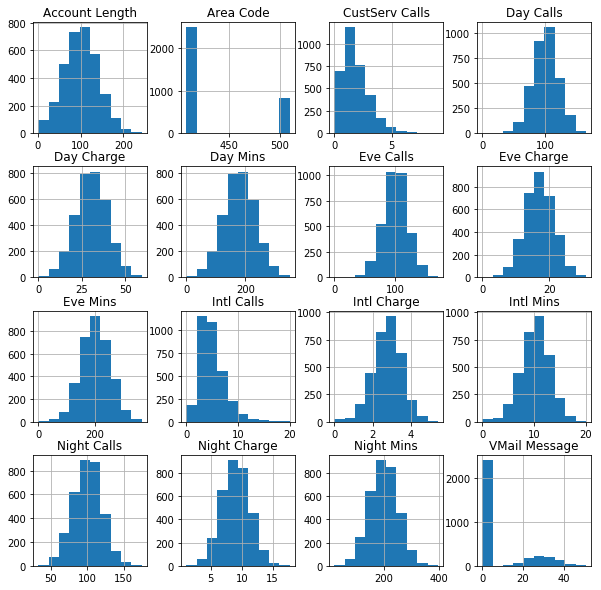

In [37]:
%matplotlib inline
hist = df.hist(figsize=(10, 10))

Most of the numeric features show guassian distribution, except for VMail Message.
Area code is coming as a numeric feature, need to convert it into numeric.

In [38]:
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


col_0,% observations
Phone,
327-1058,0.0003
327-1319,0.0003
327-3053,0.0003
327-3587,0.0003
327-3850,0.0003
327-3954,0.0003
327-4795,0.0003
327-5525,0.0003
327-5817,0.0003


col_0,% observations
Int'l Plan,
no,0.90309
yes,0.09691


col_0,% observations
VMail Plan,
no,0.723372
yes,0.276628


col_0,% observations
Churn?,
False.,0.855086
True.,0.144914


In [39]:
pd.crosstab(index=df['State'], columns="% observations", normalize="columns")

col_0,% observations
State,
AK,0.015602
AL,0.024002
AR,0.016502
AZ,0.019202
CA,0.010201
CO,0.019802
CT,0.022202
DC,0.016202
DE,0.018302


We can see immediately that:

    State appears to be quite evenly distributed
    
    Phone takes on too many unique values to be of any practical use. It's possible parsing out the prefix could have some value, but without more context on how these are allocated, we should avoid using it.
    
    Only 14% of customers churned, so there is some class imabalance, but nothing extreme.

In [40]:
# feature engineering
df = df.drop('Phone', axis=1)
df['Area Code'] = df['Area Code'].astype(object)

Bivariate analysis
Next let's look at the relationship between each of the features and our target variable.

In [41]:
# Mapping target column to numbers to make bivariate analysis a bit easier
df["Churn?"] = df["Churn?"].map({"True.":1, "False.":0})

In [42]:
for column in df.select_dtypes(include=['object']).columns:
    if column != 'Churn?':
        display(df.groupby([column])["Churn?"].mean())

State
AK    0.057692
AL    0.100000
AR    0.200000
AZ    0.062500
CA    0.264706
CO    0.136364
CT    0.162162
DC    0.092593
DE    0.147541
FL    0.126984
GA    0.148148
HI    0.056604
IA    0.068182
ID    0.123288
IL    0.086207
IN    0.126761
KS    0.185714
KY    0.135593
LA    0.078431
MA    0.169231
MD    0.242857
ME    0.209677
MI    0.219178
MN    0.178571
MO    0.111111
MS    0.215385
MT    0.205882
NC    0.161765
ND    0.096774
NE    0.081967
NH    0.160714
NJ    0.264706
NM    0.096774
NV    0.212121
NY    0.180723
OH    0.128205
OK    0.147541
OR    0.141026
PA    0.177778
RI    0.092308
SC    0.233333
SD    0.133333
TN    0.094340
TX    0.250000
UT    0.138889
VA    0.064935
VT    0.109589
WA    0.212121
WI    0.089744
WV    0.094340
WY    0.116883
Name: Churn?, dtype: float64

Area Code
408    0.145585
415    0.142598
510    0.148810
Name: Churn?, dtype: float64

Int'l Plan
no     0.114950
yes    0.424149
Name: Churn?, dtype: float64

VMail Plan
no     0.167151
yes    0.086768
Name: Churn?, dtype: float64

Churn seems to be affected by State.

Area code has almost no affect.

Customers with Int'l plan and without VMail Plan churn more

Account Length


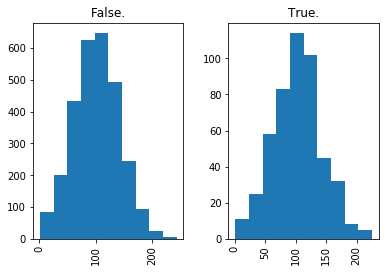

VMail Message


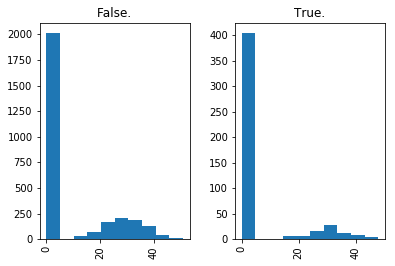

Day Mins


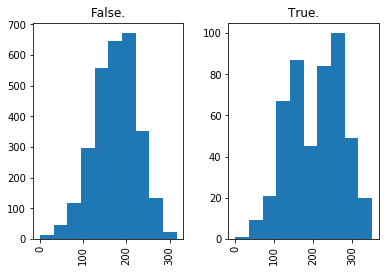

Day Calls


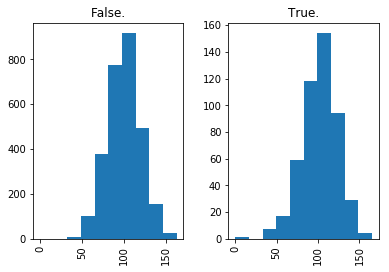

Day Charge


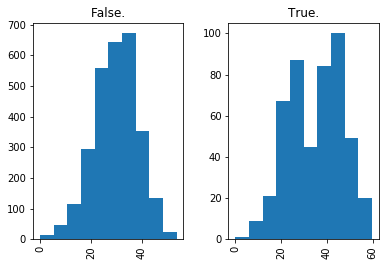

Eve Mins


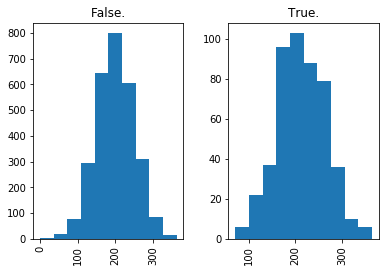

Eve Calls


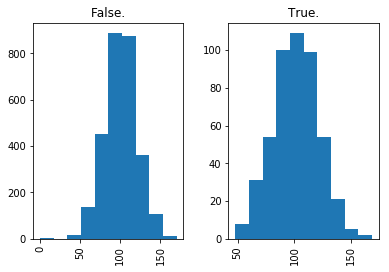

Eve Charge


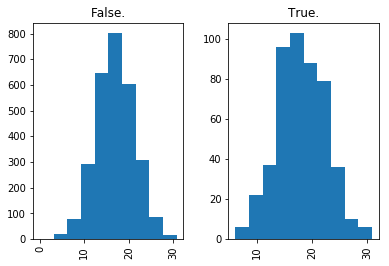

Night Mins


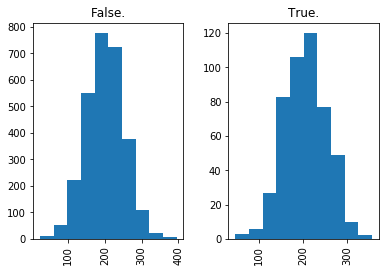

Night Calls


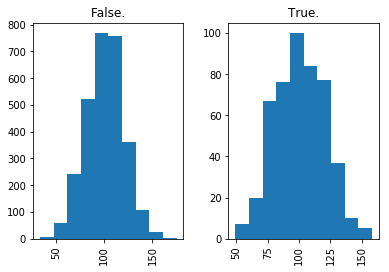

Night Charge


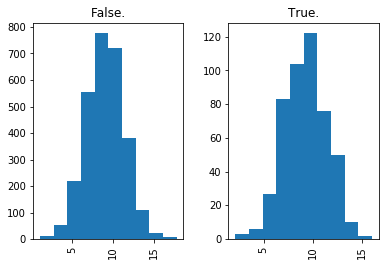

Intl Mins


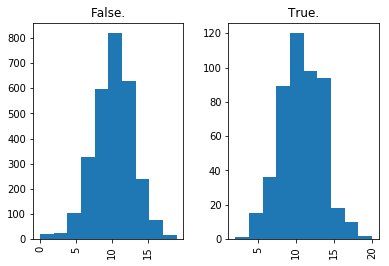

Intl Calls


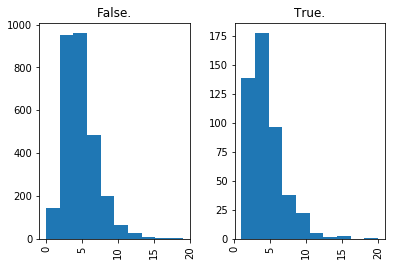

Intl Charge


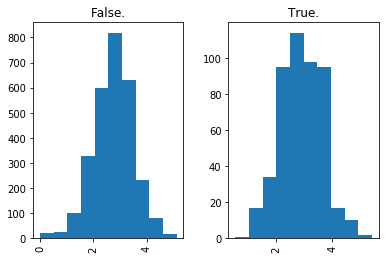

CustServ Calls


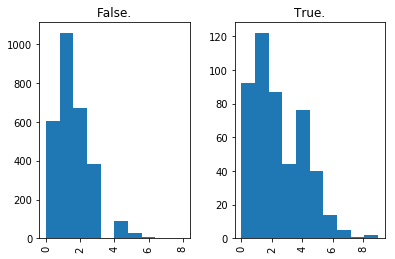

In [43]:
df["Churn?"] = df["Churn?"].map({1:"True.", 0:"False."})
for column in df.select_dtypes(exclude=['object']).columns:
    print(column)
    hist = df[[column, 'Churn?']].hist(by='Churn?')
    plt.show()

To exhibit some bimodality in daily minutes (either higher or lower than the average for non-churners)
To have a larger number of customer service calls (which makes sense as we'd expect customers who experience lots of problems may be more likely to churn)

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
Account Length,1.000000,-0.004628,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.020661,0.009546,-0.003796
VMail Message,-0.004628,1.000000,0.000778,-0.009548,0.000776,0.017562,-0.005864,0.017578,0.007681,0.007123,0.007663,0.002856,0.013957,0.002884,-0.013263
Day Mins,0.006216,0.000778,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,0.008033,-0.010092,-0.013423
Day Calls,0.038470,-0.009548,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.004574,0.021666,-0.018942
Day Charge,0.006214,0.000776,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,0.008032,-0.010094,-0.013427
Eve Mins,-0.006757,0.017562,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,0.002541,-0.011067,-0.012985
Eve Calls,0.019260,-0.005864,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.017434,0.008674,0.002423
Eve Charge,-0.006745,0.017578,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,0.002541,-0.011074,-0.012987
Night Mins,-0.008955,0.007681,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.012353,-0.015180,-0.009288
Night Calls,-0.013176,0.007123,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,0.000305,-0.013630,-0.012802


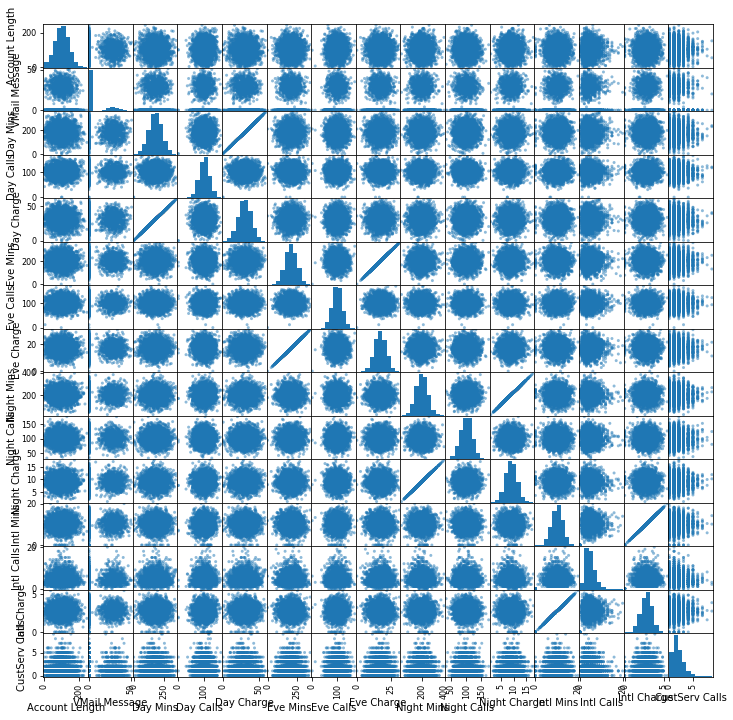

In [44]:
display(df.corr())
pd.plotting.scatter_matrix(df, figsize=(12, 12))
plt.show()

We see that churners take on very similar distributions for features like Day Mins and Day Charge. That's not surprising as we'd expect minutes spent talking to correlate with charges.

In [45]:
# feature selection
df = df.drop(['Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis=1)

Let's convert our categorical features into numeric features.

In [46]:
model_data = pd.get_dummies(df)
model_data = pd.concat([model_data['Churn?_True.'], model_data.drop(['Churn?_False.', 'Churn?_True.'], axis=1)], axis=1)

And now let's split the data into training, validation, and test sets. This will help prevent us from overfitting the model, and allow us to test the models accuracy on data it hasn't already seen.

In [47]:
len(model_data)

3333

In [48]:
train_data, validation_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data)), int(0.9 * len(model_data))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)

Now we'll upload these files to S3.

In [49]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

### 3. Training model

In [50]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'xgboost')

	get_image_uri(region, 'xgboost', 0.90-1).


Then, because we're training with the CSV file format, we'll create s3_inputs that our training function can use as a pointer to the files in S3.

In [51]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='csv')
s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'output')

Create an instance of the sagemaker.estimator.Estimator class. 

In [52]:
from time import gmtime, strftime

xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

Set the hyperparameter values for xgboost

In [53]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              subsample=0.8,
                              silent = 0,
                              objective = 'binary:logistic',
                              num_round = 100)

To start model training, call the estimator's fit method. 

In [54]:
xgb_model.fit({'train': s3_input_train, 'validation': s3_input_validation}) 

2019-09-22 22:57:42 Starting - Starting the training job...
2019-09-22 22:57:43 Starting - Launching requested ML instances......
2019-09-22 22:59:12 Starting - Preparing the instances for training......
2019-09-22 23:00:09 Downloading - Downloading input data...
2019-09-22 23:00:43 Training - Downloading the training image...
2019-09-22 23:01:08 Uploading - Uploading generated training model
Arguments: train
[2019-09-22:23:01:03:INFO] Running standalone xgboost training.
[2019-09-22:23:01:03:INFO] File size need to be processed in the node: 0.46mb. Available memory size in the node: 8610.04mb
[2019-09-22:23:01:03:INFO] Determined delimiter of CSV input is ','
[23:01:03] S3DistributionType set as FullyReplicated
[23:01:03] 2333x69 matrix with 160977 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2019-09-22:23:01:03:INFO] Determined delimiter of CSV input is ','
[23:01:03] S3DistributionType set as FullyReplicated
[23:01:03] 666x69 matrix with 45954 


2019-09-22 23:01:14 Completed - Training job completed
Billable seconds: 65



### Plotting evaluation metrics
Evaluation metrics for the completed training job are available in CloudWatch. We can pull the area under curve metric for the validation data set and plot it to see the performance of the model over time.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


   timestamp       metric_name     value
0        0.0  validation:error  0.066066
1        0.0       train:error  0.024861


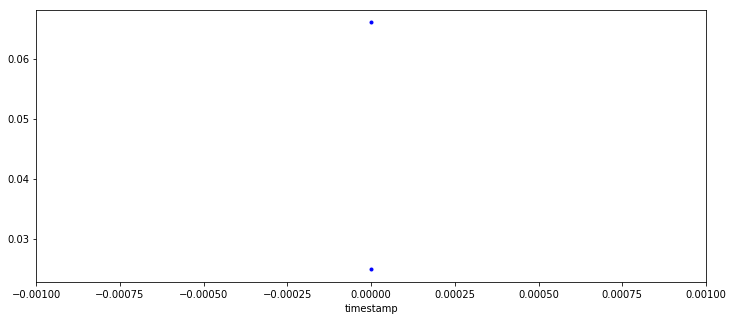

In [55]:
%matplotlib inline
from sagemaker.analytics import TrainingJobAnalytics

job_name = xgb_model._current_job_name
#print(job_name)

#metric_name = 'validation:rmse'
#metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name, metric_names=[metric_name]).dataframe()

metrics_dataframe = TrainingJobAnalytics(training_job_name=job_name).dataframe()
print(metrics_dataframe)

plt = metrics_dataframe.plot(kind='line', figsize=(12,5), x='timestamp', y='value', style='b.', legend=False)
#plt.set_ylabel(metric_name);

### 4. Deploy the model
Deploy the model that you trained in Create and Run a Training Job (Amazon SageMaker Python SDK) by calling the deploy method of the sagemaker.estimator.Estimator object. This is the same object that you used to train the model. When you call the deploy method, specify the number and type of ML instances that you want to use to host the endpoint. 

In [56]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                                instance_type='ml.m4.xlarge',
                                )

---------------------------------------------------------------------------------------------------!

### 5. Evaluate

Now that we have a hosted endpoint running, we can make real-time predictions from our model very easily, simply by making an http POST request. But first, we'll need to setup serializers and deserializers for passing our test_data NumPy arrays to the model behind the endpoint.

In [57]:
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer
xgb_predictor.deserializer = None

Now, we'll use a simple function to:

    Loop over our test dataset
    Split it into mini-batches of rows
    Convert those mini-batchs to CSV string payloads
    Retrieve mini-batch predictions by invoking the XGBoost endpoint
    Collect predictions and convert from the CSV output our model provides into a NumPy array

In [58]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, xgb_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

dtest = test_data.as_matrix()
predictions = []
for i in range(dtest.shape[0]):
    predictions.append(predict(dtest[i:i+1, 1:]))
predictions = np.array(predictions).squeeze()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [59]:
pd.crosstab(index=test_data.iloc[:, 0], columns=np.round(predictions), rownames=['actual'], colnames=['predictions'])

predictions,0.0,1.0
actual,,
0,282,4
1,9,39


Clean-up¶

If you're ready to be done with this notebook, please run the cell below. This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [ ]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)